In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Imports

In [13]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

Dataset

Loading contents from file...


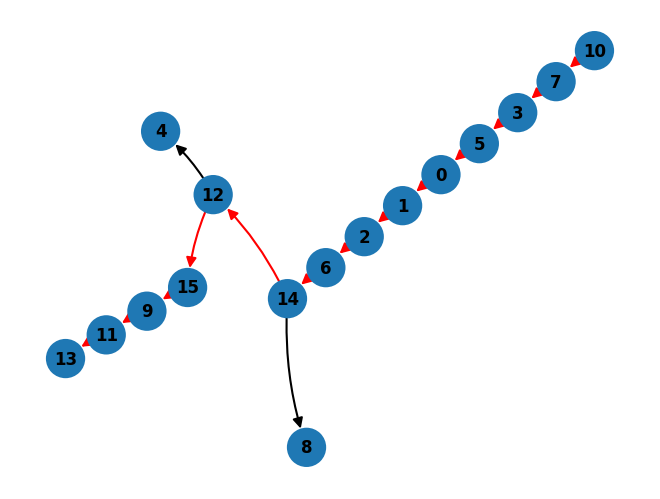

In [14]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

Model

In [15]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

Cache Activations

In [16]:
act_names = ["blocks.1.ln2.hook_normalized", "blocks.2.ln2.hook_normalized", "blocks.3.ln2.hook_normalized", "blocks.4.ln2.hook_normalized", "blocks.5.ln2.hook_normalized", "ln_final.hook_normalized"]
model.reset_hooks()

if not os.path.exists("activations.pt"):
    print("Generating activations...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=32_000,
        path_length=7,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        path_length=7,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , "activations.pt")
else:
    acts, graphs, test_acts, test_graphs = torch.load("activations.pt")

In [17]:
def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # Find neighboring nodes for each pos in edgelist
        path = [int(x.replace(">", "")) for x in labels[start_idx-1:end_idx-1]]
        path_arr = np.zeros((16,))
        path_arr[path] = 1.
        y.append(path_arr)
        # Iterate over all layers residual streams
        for key in X.keys():
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

In [18]:
dataX.keys()

dict_keys(['blocks.1.ln2.hook_normalized', 'blocks.2.ln2.hook_normalized', 'blocks.3.ln2.hook_normalized', 'blocks.4.ln2.hook_normalized', 'blocks.5.ln2.hook_normalized', 'ln_final.hook_normalized'])

SAE

In [19]:
# note: increasing sae dim beyond d_model might not be necessary here, as the model might not need more in our synthetic task. If our current sae is weird, we might study how different sae dims affect the reconstruction loss

In [20]:
from sparse_coding import *

d_model = dataX['blocks.5.ln2.hook_normalized'].shape[-1]
sae = SparseCoder(num_codes=4*d_model, verbose=True)

In [ ]:
# train
sae.fit(dataX['blocks.5.ln2.hook_normalized'])
torch.save(sae.model.state_dict(), f'sae.pt')

In [21]:
# load
checkpoint = torch.load('sae.pt')
sae.construct_model(128)
sae.model.load_state_dict(checkpoint)
sae.model.to('cuda')

this is the Anthropic SAE


SparseAutoencoder()

SAE Evaluations

In [27]:
# Evaluation: Use reconstructed activations in the model and see how bad it gets

from functools import partial

def eval_model(model, dataset, test_graph):
    model.eval()
    
    # Initialize counters
    test_graph_tokens = dataset.tokenize(test_graph)
    start_idx = np.where(test_graph_tokens == dataset.start_token)[0].item() + 2
    curr_idx = start_idx

    flag = False
    while not flag and curr_idx < dataset.max_seq_length - 1:
        # Convert to pytorch
        input_tokens = torch.from_numpy(test_graph_tokens).to(torch.long).cuda()
        input_tokens[curr_idx:] = 0
        input_tokens = input_tokens.unsqueeze(0)[:, :-1]
        # Run model
        with torch.no_grad():
            outputs = model(input_tokens).argmax(-1)
            pred = outputs[0, curr_idx-1]
            test_graph_tokens[curr_idx] = pred.item()
            if pred.item() == dataset.pad_token:  # Check if we reached the goal
                flag = True
        curr_idx += 1

    final_path = dataset.untokenize(test_graph_tokens[:curr_idx])
    
    first_move_correct = dataset.tokenize(test_graph)[48] == dataset.tokenize(final_path)[48]
    return final_path, test_graph == final_path, first_move_correct


def add_sae_hook(layer):

    # Add low-rank hook
    def sae_hook(
            acts,
            hook):
        b, c, d = acts.shape  # e.g. [1, 65, 128]
        f, r = sae.model(acts)
        acts[:, 47, :] = r[:, 47, :]
        return acts

    temp_hook_fn = partial(sae_hook)
    model.blocks[layer].ln2.hook_normalized.add_hook(temp_hook_fn)


model.reset_hooks()
add_sae_hook(5)

start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  total_first_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct, first_correct = eval_model(model, dataset, graph)
      if first_correct:
        total_first_correct += 1      

  print(f"With Hook {order}: {100* total_first_correct / num_samples:.4f}%")

model.reset_hooks()
for order in ["forward", "backward", "random"]:
  total_correct = 0
  total_first_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct, first_correct = eval_model(model, dataset, graph)
      if first_correct:
        total_first_correct += 1      

  print(f"Without Hook {order}: {100* total_first_correct / num_samples:.4f}%")


With Hook forward: 100.0000%
With Hook backward: 99.6000%
With Hook random: 99.9000%
Without Hook forward: 100.0000%
Without Hook backward: 99.4000%
Without Hook random: 99.9000%


Visualizations

In [22]:
def get_learned_dict(sae):
    norms = torch.norm(sae.model.W_e, 2, dim=-1)
    return sae.model.W_e / torch.clamp(norms, 1e-8)[:, None]

dict = get_learned_dict(sae)

In [23]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange

max_seq_length = dataset.max_seq_length - 1
device = 'cuda'
sae.model.to(device)
def get_dictionary_activations(model, dataset, cache_name, autoencoder, batch_size=32):
    num_features, d_model = autoencoder.model.W_e.shape
    datapoints = len(dataset)
    dictionary_activations = torch.zeros((datapoints*max_seq_length, num_features))
    token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)
    with torch.no_grad():
        dl = DataLoader(dataset, batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            batch = batch[0][:, :-1].to(device)
            token_list[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
            _, cache = model.run_with_cache(batch.to(device))
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            batched_dictionary_activations, _ = autoencoder.model(batched_neuron_activations.cuda())
            dictionary_activations[i*batch_size*max_seq_length:(i+1)*batch_size*max_seq_length,:] = batched_dictionary_activations.cpu()
    return dictionary_activations, token_list

print("Getting dictionary activations")
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, 'blocks.5.ln2.hook_normalized', sae, batch_size=32)

Getting dictionary activations


  0%|          | 0/9375 [00:00<?, ?it/s]

In [ ]:
# look at feature density / look at features which activate a lot / highly affect logits

In [38]:

from collections import defaultdict

def get_feature_indices(feature_index, dictionary_activations, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    return found_indices

def get_feature_datapoints(found_indices, best_feature_activations, max_seq_length, dataset):
    num_datapoints = len(dataset)
    datapoint_indices =[np.unravel_index(i, (num_datapoints, max_seq_length)) for i in found_indices]
    all_activations = best_feature_activations.reshape(num_datapoints, max_seq_length).tolist()
    full_activations = []
    partial_activations = []
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for i, (md, s_ind) in enumerate(datapoint_indices):
        if s_ind == 47:
            md = int(md)
            s_ind = int(s_ind)
            full_tok = torch.tensor(dataset[md][0])
            full_text.append(dataset.untokenize(full_tok))
            tok = dataset[md][0][:s_ind+1]
            full_activations.append(all_activations[md])
            partial_activations.append(all_activations[md][:s_ind+1])
            text = dataset.untokenize(tok)
            text_list.append(text)
            token_list.append(tok)
            full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, partial_activations, full_activations


import os

# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10000

# features = [1,2,3,4,5,6,7,8,9,10]
feature = 22
uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], max_seq_length, dataset)
text_list

[]

8>0,13>4,7>13,5>6,10>9,3>12,11>2,2>3,14>10,9>8,4>15,12>1,8>5,1>7,6>11|15:14


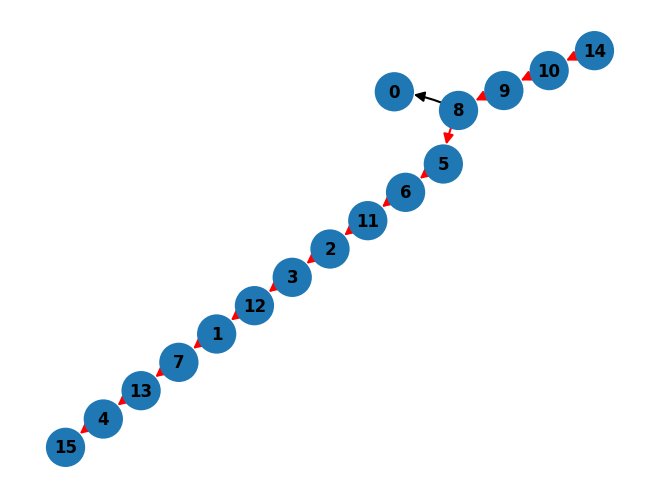

2>11,8>5,9>10,7>15,13>4,12>8,11>14,7>13,4>3,11>9,9>1,5>2,0>6,0>12,10>7|3:0


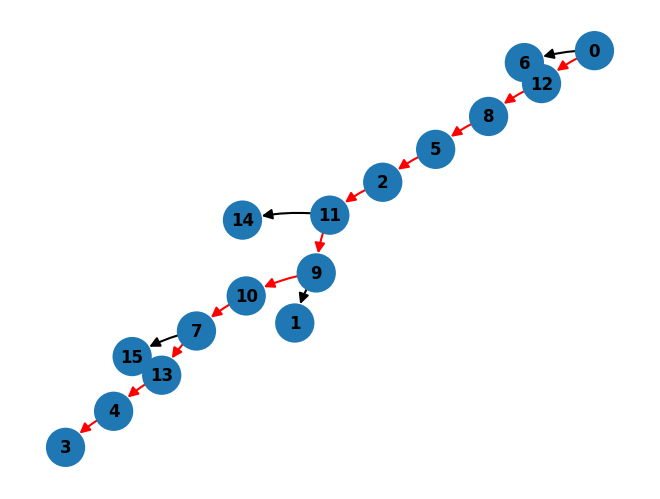

11>8,0>11,7>2,9>3,4>6,3>5,1>4,3>12,14>15,13>7,15>0,5>13,15>10,2>1,8>9|6:14


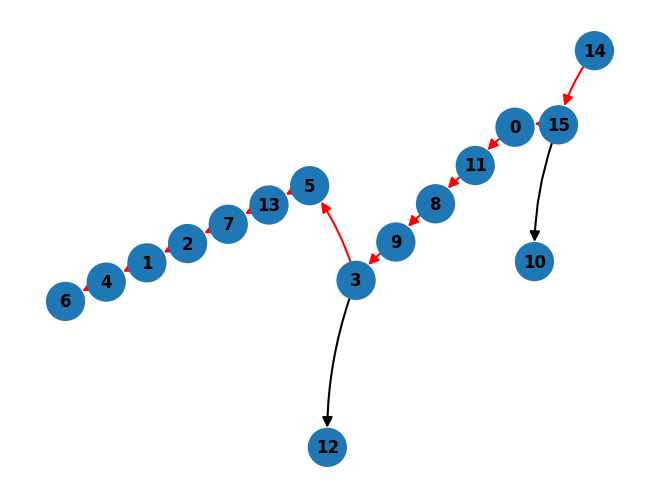

1>4,12>8,0>15,7>10,4>3,9>1,15>7,10>9,5>0,11>2,12>6,6>13,2>12,14>11,13>5|3:14


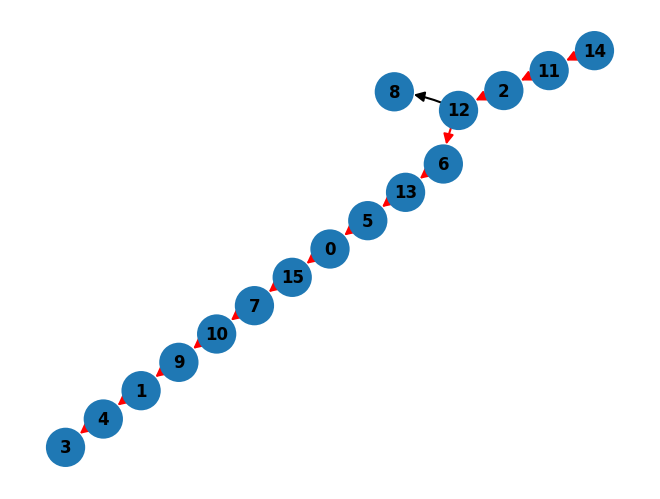

4>1,10>11,6>8,2>4,15>10,11>6,7>2,2>14,9>3,9>7,6>9,8>12,0>15,4>5,0>13|1:0


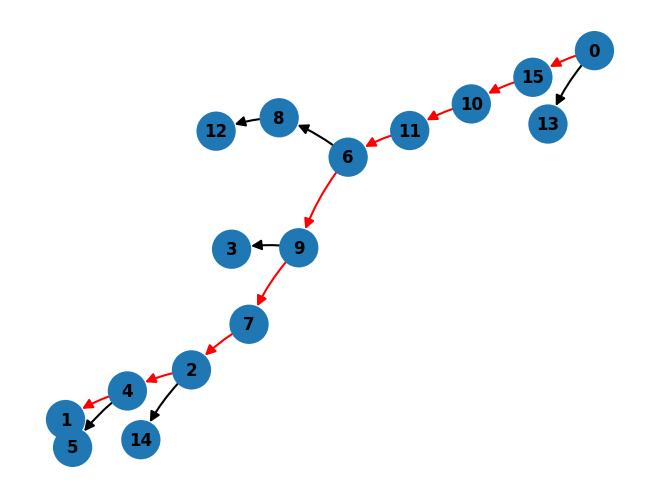

12>8,4>7,15>5,12>6,13>12,8>15,1>4,8>11,15>9,14>2,2>13,6>10,9>1,2>0,14>3|7:14


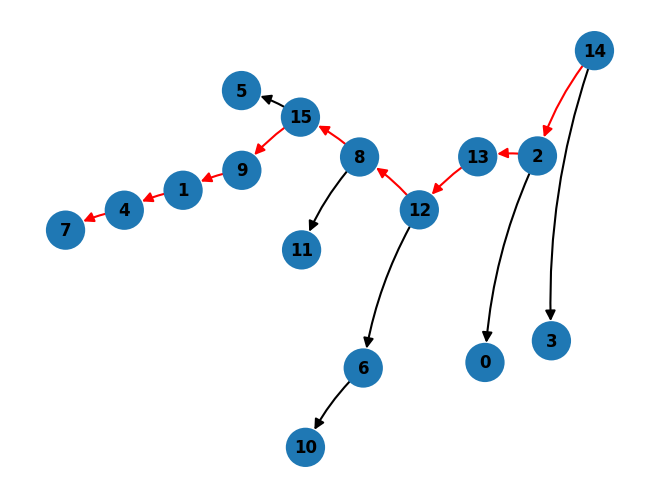

12>10,15>12,2>3,14>11,5>13,1>0,14>8,11>9,1>7,2>1,4>6,13>15,9>5,10>2,7>4|6:14


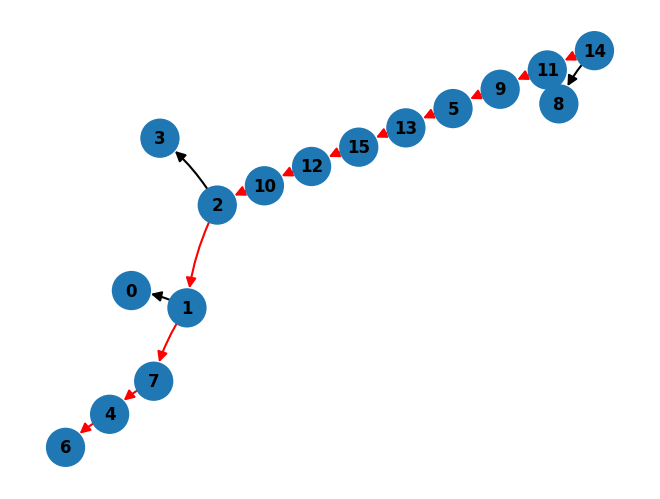

4>15,9>0,12>6,5>4,5>3,8>10,0>2,1>12,13>9,7>5,11>7,11>14,10>11,2>8,6>13|15:1


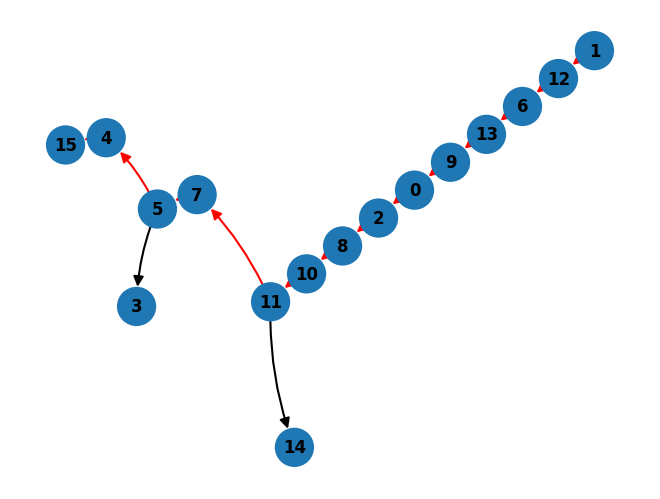

10>14,4>2,1>4,9>12,4>3,0>10,6>11,15>9,8>15,7>8,6>7,15>13,12>5,12>1,0>6|3:0


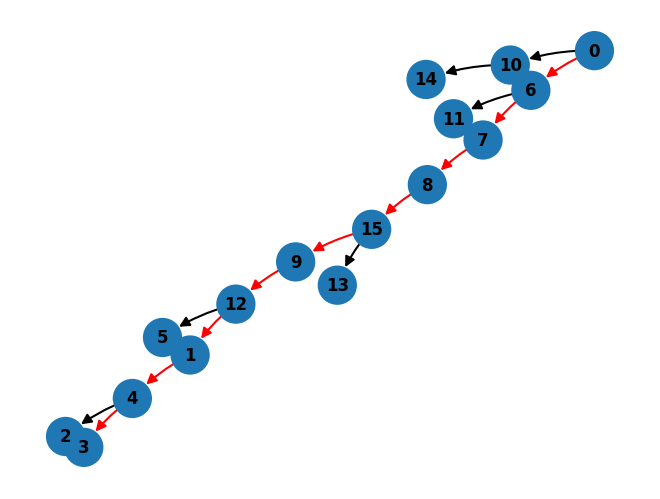

12>5,15>8,5>1,2>15,11>6,8>12,9>3,4>0,5>7,10>13,9>11,6>14,13>2,14>10,1>4|0:9


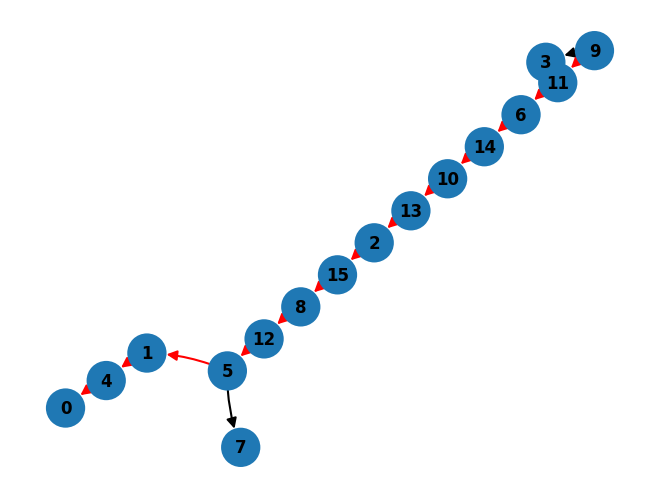

In [35]:
n = 10
for subset, full in zip(text_list[:n], full_text[:n]):
    print(subset)
    parse_example(full)
    plt.show()

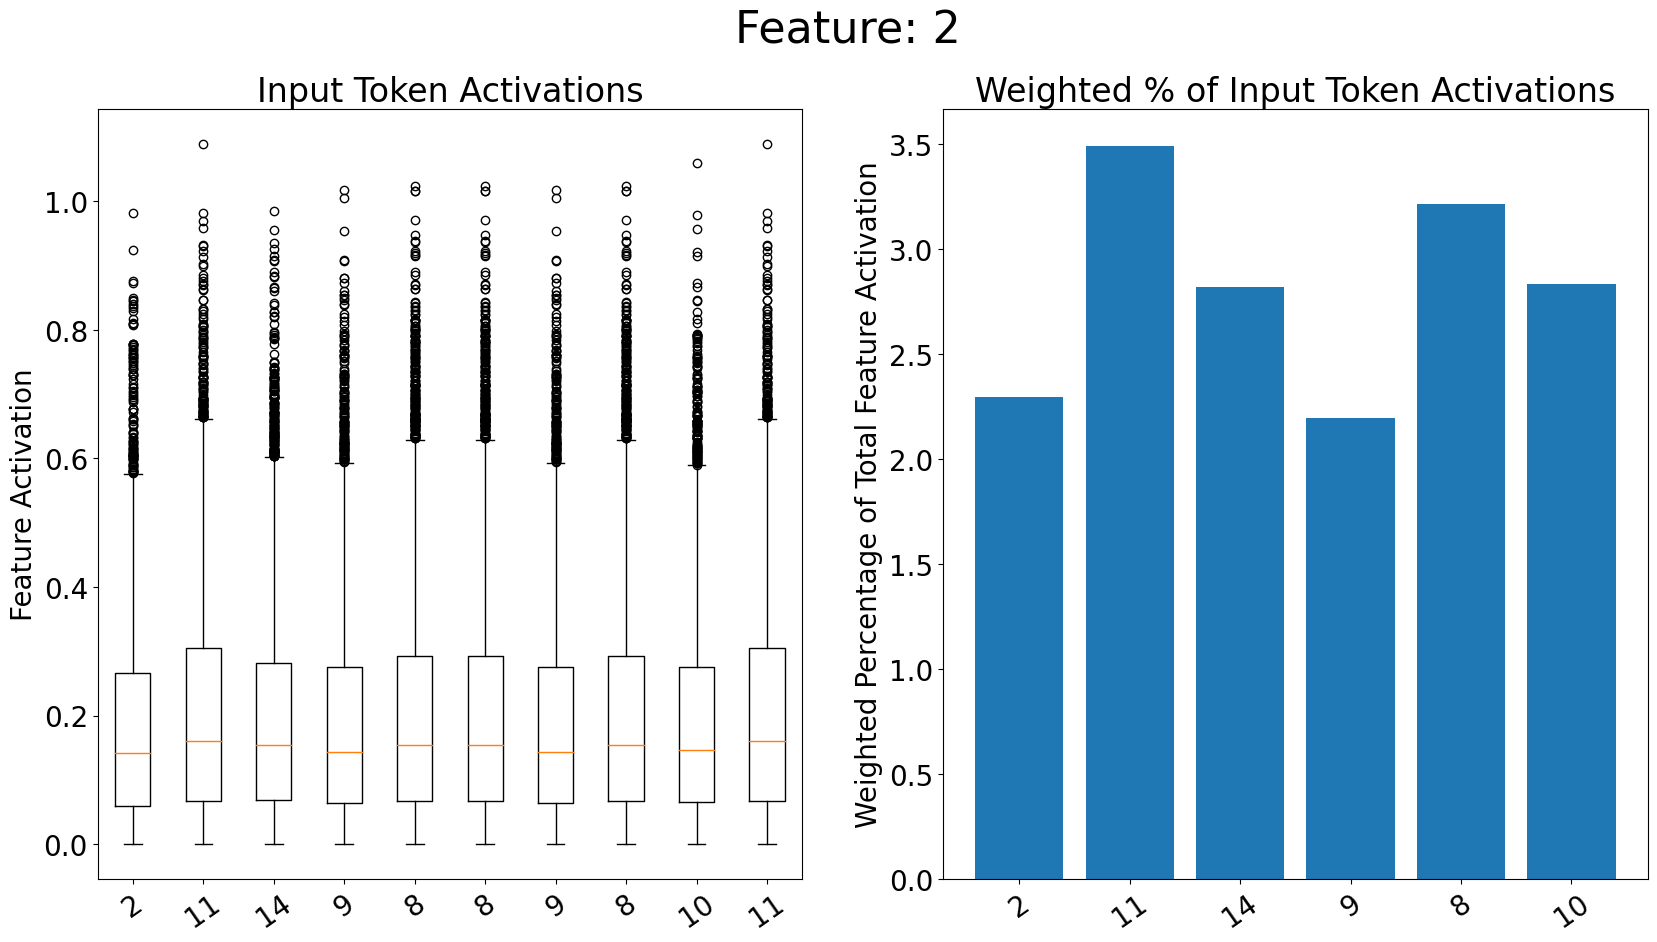

In [14]:
def get_token_statistics(feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location="", num_unique_tokens=10, setting="input", negative_threshold=-0.01):
    if(setting=="input"):
        nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
    else:
        nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
    nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

    # Unravel the indices to get the token IDs
    datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]
    all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

    # Find the max value for each unique token
    token_value_dict = defaultdict(int)
    for token, value in zip(all_tokens, nonzero_values):
        token_value_dict[token] = max(token_value_dict[token], value)
    # if(setting=="input"):
    sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
    # else:
    #     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
    # Take the top 10 (or fewer if there aren't 10)
    max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
    total_sums = nonzero_values.abs().sum()
    max_token_sums = []
    token_activations = []
    assert len(max_tokens) > 0, "No tokens found for this feature"
    for max_token in max_tokens:
        # Find ind of max token
        max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
        # Grab the values for those indices
        max_token_values = nonzero_values[max_token_indices]
        max_token_sum = max_token_values.abs().sum()
        max_token_sums.append(max_token_sum)
        token_activations.append(max_token_values)

    if(setting=="input"):
        title_text = "Input Token Activations"
        save_name = "input"
        y_label = "Feature Activation"
    else:
        title_text = "Output Logit-Difference"
        save_name = "logit_diff"
        y_label = "Logit Difference"

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Add a supreme title for the entire figure
    if(setting=="input"):
        fig.suptitle(f"Feature: {feature}", fontsize=32)

    # Boxplot on the left
    ax = axs[0]
    ax.set_title(f'{title_text}')
    max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
    ax.set_ylabel(y_label)
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.boxplot(token_activations[::-1], labels=max_text[::-1])

    # Bar graph on the right
    ax = axs[1]
    ax.set_title(f'Weighted % of {title_text}')
    plt.sca(ax)
    plt.xticks(rotation=35)
    ax.title.set_size(24)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
    ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

    # Save the figure
    plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')

    return

get_token_statistics(feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)

In [26]:
feature, feature_activation, dataset, max_seq_length, tokens_for_each_datapoint, save_location, num_unique_tokens, setting, negative_threshold = feature, dictionary_activations[:, feature], dataset, max_seq_length, tokens_for_each_datapoint, save_path, 10, "input", -0.01

if(setting=="input"):
    nonzero_indices = feature_activation.nonzero()[:, 0]  # Get the nonzero indices
else:
    nonzero_indices = (feature_activation < negative_threshold).nonzero()[:, 0]
nonzero_values = feature_activation[nonzero_indices].abs()  # Get the nonzero values

# Unravel the indices to get the token IDs
datapoint_indices = [np.unravel_index(i, (len(dataset), max_seq_length)) for i in nonzero_indices]

In [31]:
len([md for md in nonzero_values])

45405

In [ ]:
all_tokens = [dataset[int(md)][0][int(s_ind)] for md, s_ind in datapoint_indices]

In [ ]:
all_graphs = [dataset[int(md)][0] for md, s_ind in datapoint_indices]

In [ ]:
len(all_graphs)

15004650

In [ ]:
# Find the max value for each unique token
token_value_dict = defaultdict(int)
for token, value in zip(all_tokens, nonzero_values):
    token_value_dict[token] = max(token_value_dict[token], value)
# if(setting=="input"):
sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: -token_value_dict[x])
# else:
#     sorted_tokens = sorted(token_value_dict.keys(), key=lambda x: token_value_dict[x])
# Take the top 10 (or fewer if there aren't 10)
max_tokens = sorted_tokens[:min(num_unique_tokens, len(sorted_tokens))]
total_sums = nonzero_values.abs().sum()
max_token_sums = []
token_activations = []
assert len(max_tokens) > 0, "No tokens found for this feature"
for max_token in max_tokens:
    # Find ind of max token
    max_token_indices = tokens_for_each_datapoint[nonzero_indices] == max_token
    # Grab the values for those indices
    max_token_values = nonzero_values[max_token_indices]
    max_token_sum = max_token_values.abs().sum()
    max_token_sums.append(max_token_sum)
    token_activations.append(max_token_values)

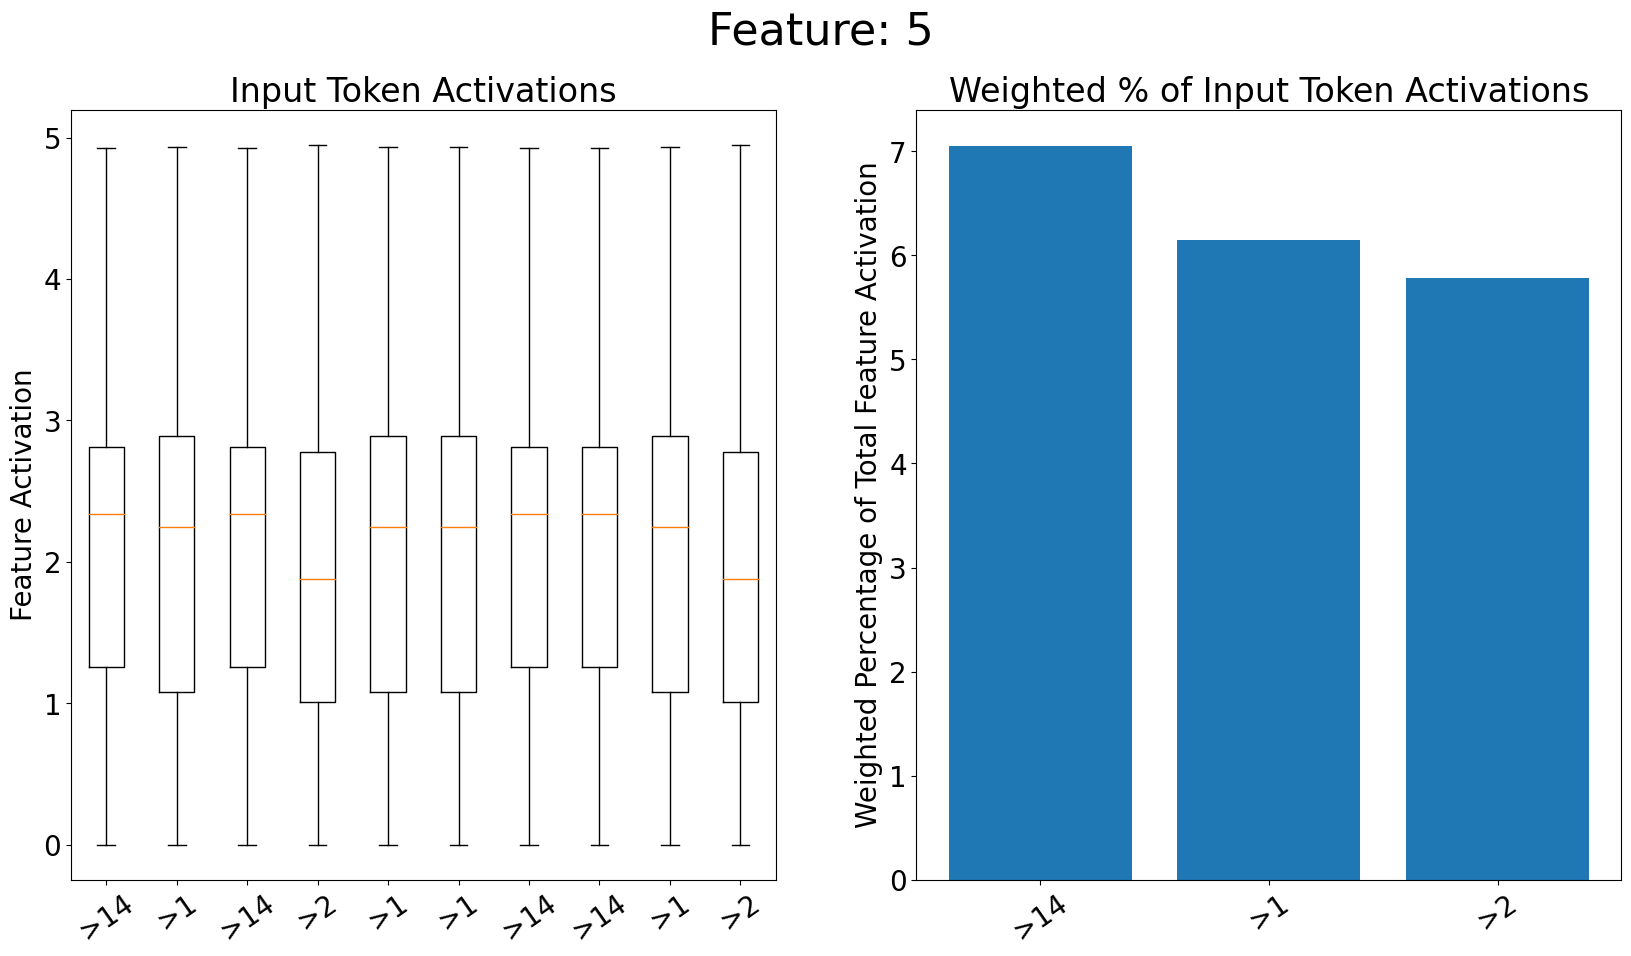

In [ ]:
if(setting=="input"):
    title_text = "Input Token Activations"
    save_name = "input"
    y_label = "Feature Activation"
else:
    title_text = "Output Logit-Difference"
    save_name = "logit_diff"
    y_label = "Logit Difference"

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Add a supreme title for the entire figure
if(setting=="input"):
    fig.suptitle(f"Feature: {feature}", fontsize=32)

# Boxplot on the left
ax = axs[0]
ax.set_title(f'{title_text}')
max_text = [dataset.untokenize([t]).replace("\n", "\\n").replace(" ", "_") for t in max_tokens]
ax.set_ylabel(y_label)
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.boxplot(token_activations[::-1], labels=max_text[::-1])

# Bar graph on the right
ax = axs[1]
ax.set_title(f'Weighted % of {title_text}')
plt.sca(ax)
plt.xticks(rotation=35)
ax.title.set_size(24)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel(f'Weighted Percentage of Total {y_label}')
ax.bar(max_text[::-1], [t/total_sums*100 for t in max_token_sums[::-1]])

# Save the figure
plt.savefig(f'{save_location}feature_{feature}_{save_name}_combined.png', bbox_inches='tight')